# Optimal planetary landing

<style>
.MathJax {
  font-family: "Common HTML";
}
</style>

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\mathrm{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> ASE3001: Computational Experiments for Aerospace Engineering, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_
_<div style="text-align: right"> Jiwoo Choi (jiwoochoi@inha.edu) </div>_

<br>

---

<br>

## Optimal landing guidance

In this problem we consider a soft landing problem for a planetary lander.

Consider the following equations of motion in the ENU (East-North-Up) frame

$$
\begin{aligned}
  \dot{p} &= v \\  
  \dot{v} &= u - \gamma v +g  \\
\end{aligned}
$$
with
$$
\begin{aligned}
    p &= (p_e, p_n, p_u)\\
    v &= (v_e, v_n, v_u) \\
        g&=(0,0,-g).
\end{aligned}
$$

where $p$ and $v$ are the position and velocity of the vehicle and $u$ represents the acceleration of the vehicle. The gravitational acceleration is denoted by $g$ and the damping coefficient is given by $\gamma$. Note that the acceleration vector as the control input can be achieved by a set of thrusters attached on the vehicle. The objective of the problem is to find the control input plan $u_0, \dots, u_{N-1}$ that drives the vehicle to $p=0$ and $v=0$ at $t=N$, from the specified initial condition.

<br>

The above system can be descretized using trapezoidal integration as follows.

$$
\begin{aligned}
  v_{t+1} &= v_t + {h}\left( u_t - \gamma v_t -g \right) \\
  &= \left(1-\gamma h\right) v_t + h u_t - hg \\
  p_{t+1} &= p_t + \frac{h}{2}\left( v_t + v_{t+1} \right)  \\
  &= p_t + \frac{h}{2}\left( v_t + \left(1-\gamma h\right) v_t + h u_t \right)  \\
  &= p_t +  \left(h-\frac{1}{2}\gamma h^2\right) v_t + \frac{1}{2} h^2 u_t
\end{aligned}
$$


Given initial points and desired points, the problem of minimizing the control input while satisfying the  dynamics of the system can be defined as follows,

$$
\begin{aligned}
    \text{minimize} \quad & \sum_{t=0}^{N-1} \left\|u_t \right\|_2^2 \\
    \text{subject to} \quad & x_{t+1} = Ax_t + Bu_t+b , \quad t=0,\dots,N-1,\\
    &x_0 = x_\text{init},\\
    &x_N = x_\text{des},
\end{aligned}
$$

where $N$ is the prediction horizon, which represents the number of future time steps considered for the optimization problem.

The above optimal control problem can be addressed using a weighted least squares approach.

In [1]:
import numpy as np
import numpy.linalg as lg

import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
from tqdm import tqdm

In [2]:
N = 100
T = 10
dt = T / N

gamma = 1e-5
g     = np.array([0, 0, -9.8])

#x_init = np.array([80,-50,350, 2,-3,-0])  # initial pe, pn, pu, ve, vn, vu at t=0
x_init = np.array([10,-5,50, 0,-1,-1])  # initial pe, pn, pu, ve, vn, vu at t=0
x_des  = np.array([0,0,0,0,0,-0.1])      # desired pe, pn, pu, ve, vn, vu at t=N

<br>

---

<br>

_**(Problem 1)**_ Construct the appearing matrices and a vector, $A$, $B$, and $b$ expressed with given parameters. Define $x = (p_e, p_n, p_u, v_e, v_n, v_u)$, and $u=(u_e, u_n, u_u)$.

In [3]:
## your code here ##
A = np.array([[1, 0, 0, (dt - 0.5*gamma*dt**2), 0, 0],
              [0, 1, 0, 0, (dt - 0.5*gamma*dt**2), 0],
              [0, 0, 1, 0, 0, (dt - 0.5*gamma*dt**2)],
              [0, 0, 0, (1 - gamma*dt), 0, 0],
              [0, 0, 0, 0, (1 - gamma*dt), 0],
              [0, 0, 0, 0, 0, (1 - gamma*dt)]])

B = np.array([[0.5*dt**2, 0, 0],
              [0, 0.5*dt**2, 0],
              [0, 0, 0.5*dt**2],
              [dt, 0, 0],
              [0, dt, 0],
              [0, 0, dt]])

b = np.array([0, 0, 0, dt*g[0], dt*g[1], dt*g[2]])


<br>

---

<br>

_**(Problem 2)**_
The original problem can be reformulated as minimizing a sum of square terms as follows.

$$
\underset{x_1,\dots,x_N, u_0,\dots,u_{N-1}}{\text{minimize}} \ \|x_N-x_\text{des}\|^2 + \sum_{t=0}^{N-1}\left\| x_{t+1}-Ax_{t}-Bu_{t}-b\right\|^2 + \sum_{t=0}^{N-1}\left\|Q_u u_t\right\|^2.
$$

Stacking the state variables and the control inputs by $x = (x_1,x_2, \dots, x_N)$, $u = (u_0, u_1, \dots, u_{N-1})$, and $y = (x, u) \in \R^{9N}$, the above problem can be expressed as the following,

$$
\underset{y}{\text{minimize}} \ \left\|Gy - c\right\|^2 + \sum_{t=0}^{N-1}\left\|Q_u u_t\right\|^2,
$$

which can again be reformulated in,

$$
\underset{y}{\text{minimize}} \ \left\|\tilde{G}y - \tilde{c}\right\|^2  ,
$$

where, $Q_u$ is a weighting matrix that regulates the size of control inputs, which in given in the code cell below.

<br>

Construct $G, \tilde{G}, c, \tilde{c}$ and make a code implementing these, noting that $G, \tilde{G}, c, \tilde{c}$ contain $A$, $B$, $b$, and $I$ (the identity matrix).

Note that the state variables $x_1, \dots, x_N$ appear in the above formulation. In other words, the decision variables of the above problem include not only the control inputs but also the state variables.

Try using the `scipy.sparse` module with indexing where possible.

In [4]:
w_u = 3e-2
Q_u = np.diag([w_u]*3)

In [5]:
import numpy as np
from scipy.sparse import lil_matrix, vstack, csr_matrix



A = np.asarray(A)
B = np.asarray(B)
b = np.asarray(b).reshape(-1)
Q_u = np.asarray(Q_u)
x0 = np.asarray(x_init).reshape(-1)
x_des = np.asarray(x_des).reshape(-1)

nx = A.shape[0]    # state dimension
nu = B.shape[1]    # input dimension

# 총 상태, 입력, 결정변수 차원
n_state_vars = N * nx        
n_input_vars = N * nu        
ny = n_state_vars + n_input_vars


G_dyn = lil_matrix((N * nx, ny))
c_dyn = np.zeros(N * nx)

for t in range(N):
    row_start = t * nx
    row_end   = (t + 1) * nx

    # u_t columns
    col_u_start = n_state_vars + t * nu
    col_u_end   = n_state_vars + (t + 1) * nu

    if t == 0:
        # x1 - A x0 - B u0 - b = 0
        G_dyn[row_start:row_end, 0:nx] = np.eye(nx)
        G_dyn[row_start:row_end, col_u_start:col_u_end] = -B
        c_dyn[row_start:row_end] = A @ x0 + b

    else:
        # x_{t+1} - A x_t - B u_t - b = 0
        col_xt_start = (t - 1) * nx
        col_xt_end   = t * nx
        G_dyn[row_start:row_end, col_xt_start:col_xt_end] = -A

        col_xtp1_start = t * nx
        col_xtp1_end   = (t + 1) * nx
        G_dyn[row_start:row_end, col_xtp1_start:col_xtp1_end] = np.eye(nx)

        G_dyn[row_start:row_end, col_u_start:col_u_end] = -B
        c_dyn[row_start:row_end] = b



G_term = lil_matrix((nx, ny))
c_term = x_des

col_xN_start = (N - 1) * nx
col_xN_end   = N * nx
G_term[:, col_xN_start:col_xN_end] = np.eye(nx)


G = vstack([G_dyn, G_term])
c = np.concatenate([c_dyn, c_term])
G = csr_matrix(G)



mu = Q_u.shape[0]

G_u = lil_matrix((N * mu, ny))
c_u = np.zeros(N * mu)

for t in range(N):
    row_start = t * mu
    row_end   = (t + 1) * mu

    col_u_start = n_state_vars + t * nu
    col_u_end   = n_state_vars + (t + 1) * nu

    G_u[row_start:row_end, col_u_start:col_u_end] = Q_u

G_u = csr_matrix(G_u)


G_tilde = vstack([G, G_u])
c_tilde = np.concatenate([c, c_u])
G_tilde = csr_matrix(G_tilde)


print("G shape:", G.shape)
print("c shape:", c.shape)
print("G_tilde shape:", G_tilde.shape)
print("c_tilde shape:", c_tilde.shape)


G shape: (606, 900)
c shape: (606,)
G_tilde shape: (906, 900)
c_tilde shape: (906,)


<br>

---

<br>

_**(Problem 3)**_
Find the optimal solution  $y^*$ to the problem using the gradient descent method. Compare this solution with the one obtained via the closed-form solution. Use the initial value `yp_init` specified in the code cell below to achieve faster convergence.

Display the optimal trajectories and the optimal control inputs. Also, check the convergence profile by examining how fast the magnitude of the gradient vectors decreases as the iterations proceed.

In [6]:
xp_init = np.linspace(x_init, x_des, num=N+1, endpoint=True)
yp_init = np.hstack([xp_init[1:].reshape(-1), *[g]*N])[:,None] # initial values

lr = 1e-1
eps_crt = 1e-4  # terminal condition of gradient descent
epochs = 300000

In [7]:
y = yp_init.astype(np.float64).reshape(-1)

grads  = []
y_hist = []
norm_list_grad =[]

for i in range(epochs):

    # ---- residual r = A y - b (SAFE) ----
    r = G_tilde.dot(y) - c_tilde

    # ---- gradient = 2 A^T r (SAFE) ----
    grad = 2 * (G_tilde.T.dot(r))   

    grads.append(grad)
    norm_list_grad.append(np.linalg.norm(grad))
    y_hist.append(y.copy())

    # ---- stopping ----
    if np.linalg.norm(grad) <= eps_crt:
        break

    # ---- gradient descent ----
    y = y - lr * grad

y_gd = y

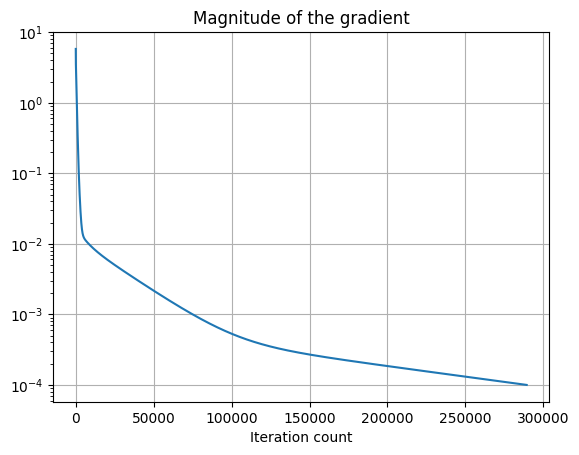

In [8]:
## your code here ##
plt.semilogy(norm_list_grad)
plt.xlabel("Iteration count")
plt.title("Magnitude of the gradient")
plt.grid(True)
plt.show()

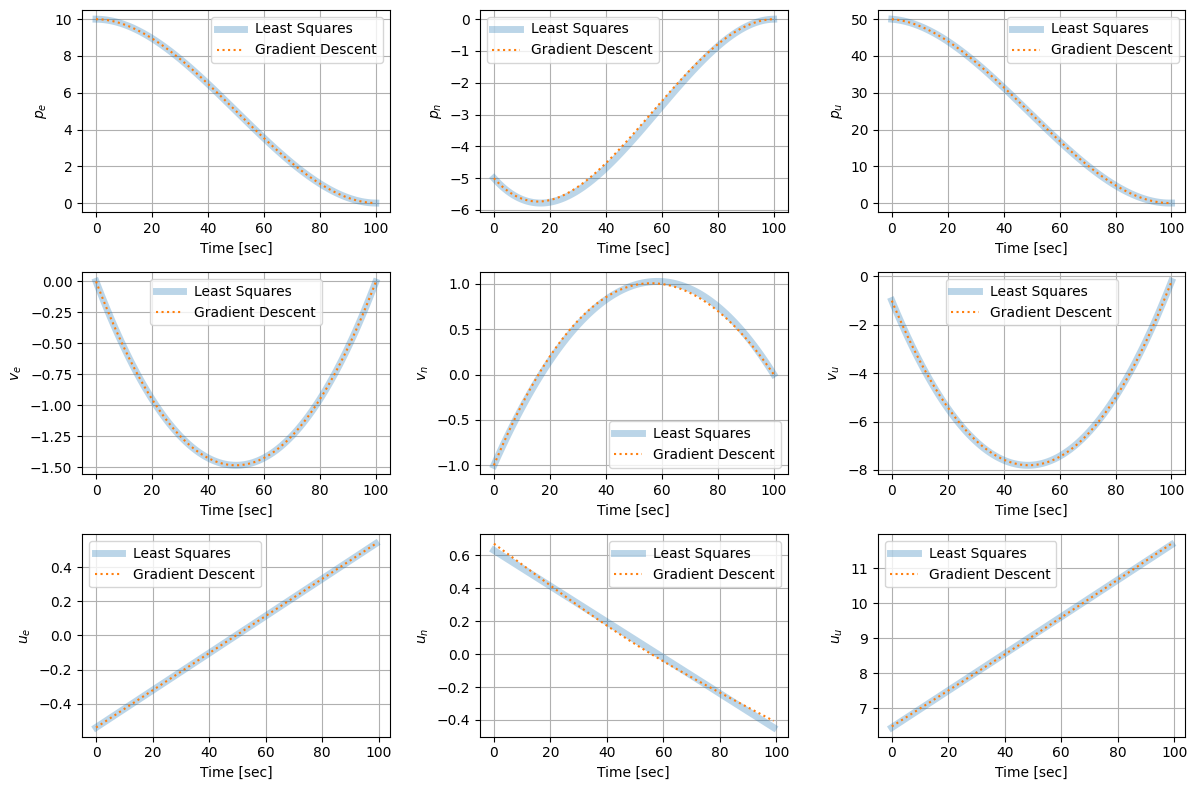

In [9]:
## your code here ##
G_dense = G_tilde.toarray()
y_lstsq = np.linalg.lstsq(G_dense, c_tilde, rcond=-1)[0]

x_lstsq = np.zeros((N, nx))
x_opt   = np.zeros((N, nx))
u_lstsq = np.zeros((N, nu))
u_opt   = np.zeros((N, nu))

for i in range(N):
    # 상태복원
    for j in range(nx):
        x_lstsq[i, j] = y_lstsq[i*nx + j]
        x_opt[i, j]   = y_gd[i*nx + j]

    for k in range(nu):
        u_lstsq[i, k] = y_lstsq[6*N + 3*i + k]
        u_opt[i, k]   = y_gd[6*N + 3*i + k]



x_ls_array = x_lstsq.copy()
x_gd_array = x_opt.copy()

u_ls_array = u_lstsq.copy()
u_gd_array = u_opt.copy()


x_ls_array = np.vstack((x_init, x_ls_array))
x_gd_array = np.vstack((x_init, x_gd_array))


opt_linewidth = 5
opt_alpha = 0.3
ls_label = 'Least Squares'
gd_label = 'Gradient Descent'
x_label = 'Time [sec]'

y_label = ['$p_e$', '$p_n$', '$p_u$', '$v_e$', '$v_n$', '$v_u$', '$u_e$', '$u_n$', '$u_u$']

plt.figure(figsize=(12, 8), dpi=100)

# === Plot states ===
for i in range(nx):
    plt.subplot(3, 3, i + 1)
    plt.plot(x_ls_array[:, i], linewidth=opt_linewidth, alpha=opt_alpha, label=ls_label)
    plt.plot(x_gd_array[:, i], linestyle=':', label=gd_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label[i])
    plt.grid()
    plt.legend()

# === Plot inputs ===
for i in range(nu):
    plt.subplot(3, 3, i + 7)
    plt.plot(u_ls_array[:, i], linewidth=opt_linewidth, alpha=opt_alpha, label=ls_label)
    plt.plot(u_gd_array[:, i], linestyle=':', label=gd_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label[i + 6])
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()


<br>

---

<br>

## Optimal Control Under Constraints

Optimal control problems often involve constraints that limit the possible values of control inputs and/or states. These constraints are crucial for ensuring that the obtained solution is physically realizable, safe, and adheres to operational limitations.

### Types of Constraints:
*   **Control Input Limits**: These define the maximum and minimum values that the control inputs (e.g., thrust, acceleration) can take. For a planetary lander, this might mean limits on the thruster magnitude or direction due to hardware capabilities.
    $$u_{\text{min}} \leq u_t \leq u_{\text{max}}$$
*   **State Bounds**: These define the allowable range for the state variables (e.g., position, velocity). For instance, the lander's position might be constrained to be above a certain altitude, or its velocity might have a maximum limit for structural integrity.
    $$x_{\text{min}} \leq x_t \leq x_{\text{max}}$$
*   **Terminal Constraints**: These are specific conditions that must be met at the end of the trajectory, such as reaching a specific position and velocity (as in our soft landing problem where $x_N = x_{\text{des}}$).

### Significance of Constraints:
Constraints are vital because they:
*   **Reflect Physical Reality**: They ensure the solution respects the real-world limitations of the system. Without them, an optimizer might suggest impossibly large control forces or states.
*   **Ensure Safety**: They can prevent the system from entering unsafe operating regimes (e.g., crashing, exceeding structural limits).
*   **Define Operational Envelopes**: They specify the boundaries within which the system is designed to operate effectively.
*   **Impact Solution Feasibility**: Including constraints can significantly alter the optimal trajectory and control sequence, making the problem more challenging but leading to a practical solution.

<br>

---

<br>

## Projected Gradient Descent

### Projected Gradient Descent (PGD)

Projected Gradient Descent is an iterative optimization algorithm used to find the minimum of a function subject to constraints. It extends the standard gradient descent method by incorporating a projection step to ensure that the updated solution remains within the feasible set defined by the constraints.

The algorithm proceeds in two main steps at each iteration:

1.  **Gradient Descent Step (Unconstrained Step):** In this step, a standard gradient descent update is performed without considering any constraints. The objective is to move in the direction that most rapidly decreases the function value.

    Mathematically, given the current iterate $x^{(k)}$ and the objective function $f(x)$, the unconstrained step computes a candidate next iterate $\tilde{x}^{(k+1)}$ as:

    $$\tilde{x}^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})$$

    where $\alpha > 0$ is the learning rate (step size), and $\nabla f(x^{(k)})$ is the gradient of the objective function at $x^{(k)}$.

2.  **Projection Step:** After the unconstrained gradient step, the candidate solution $\tilde{x}^{(k+1)}$ might lie outside the feasible set. The projection step then maps $\tilde{x}^{(k+1)}$ back onto the feasible set to satisfy the constraints. The projection typically finds the point within the feasible set that is closest to $\tilde{x}^{(k+1)}$.

    Mathematically, the projection is denoted by $P_{{C}}(\cdot)$, where ${C}$ is the feasible set. The projected iterate $x^{(k+1)}$ is given by:

    $$x^{(k+1)} = P_{{C}}(\tilde{x}^{(k+1)})$$

    The projection $P_{{C}}(y)$ is formally defined as:

    $$P_{{C}}(y) = \argmin_{z \in {C}} \|z - y\|_2^2$$

    This ensures that $x^{(k+1)}$ is the closest point in the feasible set ${C}$ to $\tilde{x}^{(k+1)}$.

By repeatedly applying these two steps, Projected Gradient Descent iteratively refines the solution, moving towards the minimum of the function while always staying within the defined constraints. The convergence properties of PGD are similar to those of standard gradient descent, but with the added complexity and computational cost of the projection step.

## Control Constraints


The minimum and maximum allowable values for the control input `u` are given below as NumPy arrays `u_min` and `u_max` respectively.



In [10]:
u_min = np.array([-0.5, -0.5, 0])
u_max = np.array([0.5, 0.5, 10])

<br>

---

<br>

_**(Problem 4)**_
Implement a Python function `project_onto_feasible_set()` that performs the projection operation onto the feasible set defined by the control input constraints. This function will take the full solution vector `y` and apply clipping based on `u_min` and `u_max` to the control input portion of `y`.


In [11]:
def project_onto_feasible_set(y):

    ## your code here ##
    x_part = y[:nx*N]
    u_part = y[nx*N:]

    u_min_stack = np.zeros(nu*N)
    u_max_stack = np.zeros(nu*N)

    for i in range(N):
        u_min_stack[i*3:i*3+3] = u_min
        u_max_stack[i*3:i*3+3] = u_max

    u_project = np.clip(u_part, u_min_stack, u_max_stack)

    y_projected = np.concatenate([x_part,u_project])

    return y_projected

<br>

---

<br>

_**(Problem 5)**_
Implement the Projected Gradient Descent (PGD) algorithm to find the optimal solution `y_pgd`, incorporating the `project_onto_feasible_set` function.

#### Instructions
1. Initialize `y_pgd` with `yp_init`.
2. In each iteration of the gradient descent loop:
    a. Calculate the gradient `grad` using `func_grad`.
    b. Perform the unconstrained gradient descent step to get `y_new_unconstrained`.
    c. Apply the `project_onto_feasible_set` function to `y_new_unconstrained` to get `y_new_pgd`, ensuring constraints are met.
    d. Update `y_pgd` with `y_new_pgd`.
    e. Store the norm of the gradient for convergence plotting.
    f. Break the loop if the gradient norm falls below `eps_crt`.

<br>

After you implement the PGD algorithm, visualize its convergence profile by plotting the magnitude of the gradient over iterations, similar to the previous gradient descent plot. This will show how quickly the algorithm converged.

<br>

In addition, visualize the resulting optimal trajectories (states) and control inputs, and compare them with the previously calculated solutions (unconstrained GD and closed-form least norm solution). This will demonstrate the effect of the constraints.

In [12]:
## your code here ##
def func_grad(y):
    r = G_tilde.dot(y) - c_tilde   # residual (정확)
    grad = 2 * (G_tilde.T.dot(r))  # gradient
    return grad

y_pgd = yp_init.reshape(-1).copy()
grads_pgd = []


for k in range(epochs):
    grad = func_grad(y_pgd)
    g_norm = np.linalg.norm(grad)
    grads_pgd.append(g_norm)

    # unconstrained GD step
    y_new = y_pgd - lr * grad
    # projection step
    y_pgd = project_onto_feasible_set(y_new)

    if g_norm < eps_crt:
        break
## your code here ##

print(f"PGD converged in {len(grads_pgd)} iterations.")
print(f"Final gradient norm: {grads_pgd[-1]:.2e}")

PGD converged in 300000 iterations.
Final gradient norm: 4.98e-02


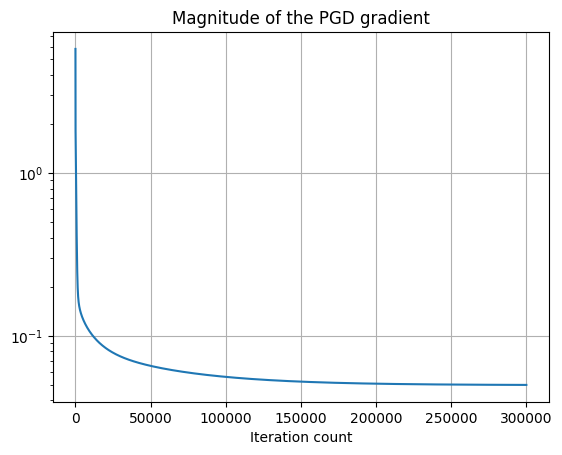

In [13]:
## your code here ##
plt.semilogy(grads_pgd)
plt.xlabel("Iteration count")
plt.title("Magnitude of the PGD gradient")
plt.grid(True)
plt.show()

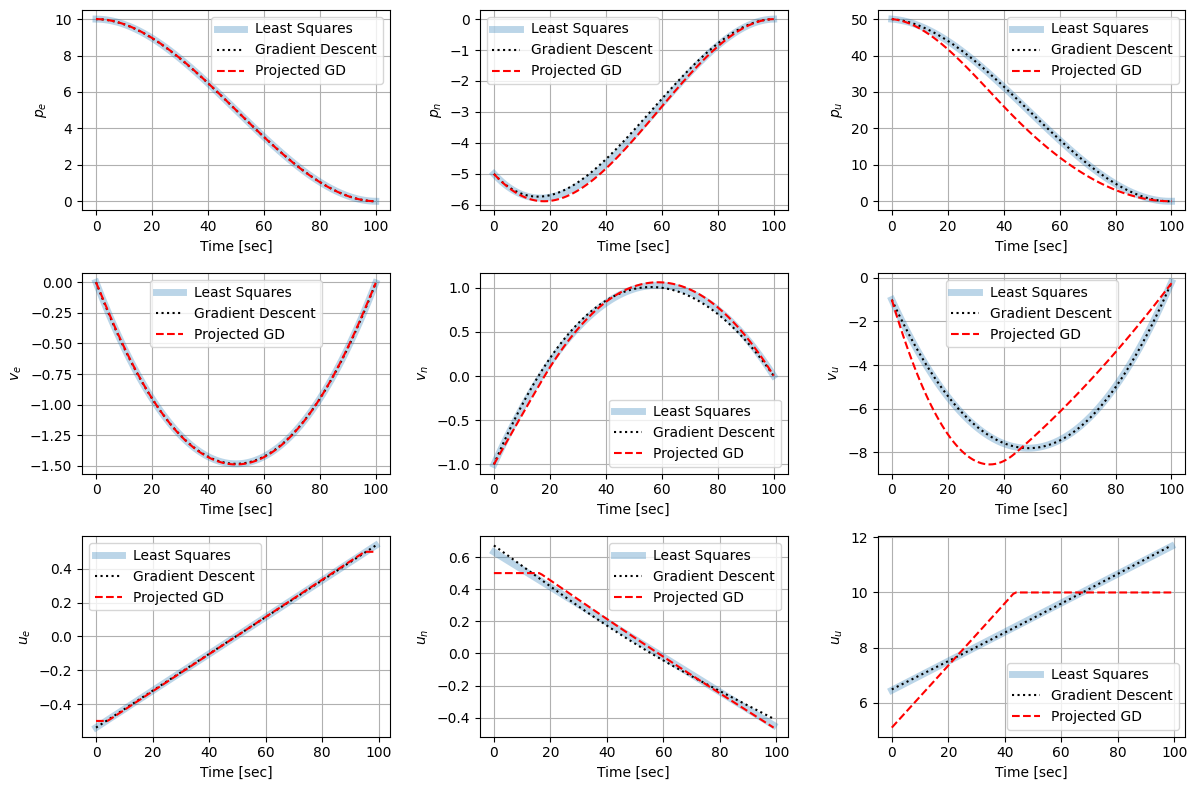

In [14]:
## your code here ##
x_pgd = np.zeros((N, nx))
u_pgd = np.zeros((N, nu))

for i in range(N):
    x_pgd[i, :] = y_pgd[i*nx : (i+1)*nx]
    u_pgd[i, :] = y_pgd[N*nx + i*nu : N*nx + (i+1)*nu]

x_pgd_array = np.vstack((x_init, x_pgd))


x_ls_array = x_lstsq.copy()
x_gd_array = x_opt.copy()

x_ls_array = np.vstack((x_init, x_ls_array))
x_gd_array = np.vstack((x_init, x_gd_array))

u_ls_array = u_lstsq.copy()
u_gd_array = u_opt.copy()
u_pgd_array = u_pgd.copy()


# === Plot ===
plt.figure(figsize=(12, 8), dpi=100)

opt_linewidth = 5
opt_alpha = 0.3

ls_label  = 'Least Squares'
gd_label  = 'Gradient Descent'
pgd_label = 'Projected GD'

y_label = ['$p_e$', '$p_n$', '$p_u$', '$v_e$', '$v_n$', '$v_u$', '$u_e$', '$u_n$', '$u_u$']
x_label = 'Time [sec]'

# === states (6 plots) ===
for i in range(nx):
    plt.subplot(3, 3, i + 1)

    plt.plot(x_ls_array[:, i],
             linewidth=opt_linewidth, alpha=opt_alpha,
             label=ls_label)

    plt.plot(x_gd_array[:, i],
             linestyle=':', color='k',
             label=gd_label)

    plt.plot(x_pgd_array[:, i],
             linestyle='--', color='r',
             label=pgd_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label[i])
    plt.grid()
    plt.legend()

# === controls (3 plots) ===
for i in range(nu):
    plt.subplot(3, 3, i + 7)

    plt.plot(u_ls_array[:, i],
             linewidth=opt_linewidth, alpha=opt_alpha,
             label=ls_label)

    plt.plot(u_gd_array[:, i],
             linestyle=':', color='k',
             label=gd_label)

    plt.plot(u_pgd_array[:, i],
             linestyle='--', color='r',
             label=pgd_label)

    plt.xlabel(x_label)
    plt.ylabel(y_label[i + 6])
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()




<br>

---

<br>

_**(Problem 5)**_
Extract the optimal position trajectory from the PGD solution and create a 3D plot to visualize the lander's path, comparing it with the unconstrained (Least Squares) solution.

First, extract the position components $(p_e, p_n, p_u)$ from both the `x_pgd` (Projected Gradient Descent) and `x_opt` (Least Squares) arrays for plotting. These correspond to the first three columns of the state vectors.

Import `Axes3D` and create a 3D plot to visualize and compare the optimal trajectories from the PGD and Least Squares solutions, as specified in the instructions.


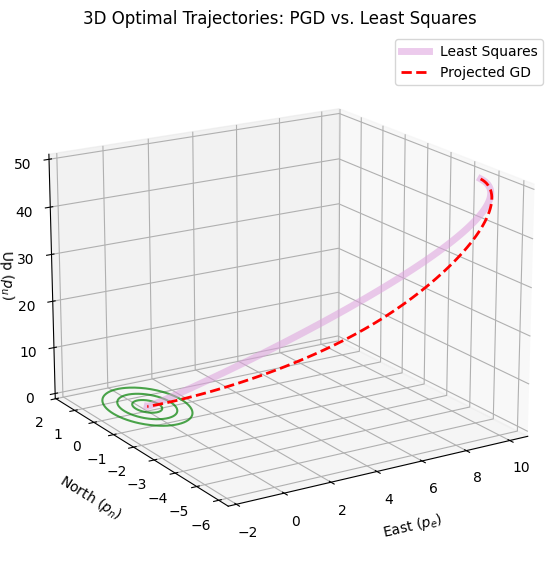

In [37]:
from mpl_toolkits.mplot3d import Axes3D

# --- Extract position trajectories (pe, pn, pu) ---
pe_ls  = x_ls_array[:, 0]
pn_ls  = x_ls_array[:, 1]
pu_ls  = x_ls_array[:, 2]

pe_pgd = x_pgd_array[:, 0]
pn_pgd = x_pgd_array[:, 1]
pu_pgd = x_pgd_array[:, 2]

# ===============================
#     3D Plot
# ===============================
fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(111, projection='3d')

radii = [0.5, 1.0, 1.5]
theta = np.linspace(0, 2*np.pi, 200)
p_e_des, p_n_des, p_u_des = x_des[:3]  

for r in radii:
    circle_x = p_e_des + r * np.cos(theta)
    circle_y = p_n_des + r * np.sin(theta)
    circle_z = np.zeros_like(theta)     # z = 0 plane
    ax.plot(circle_x, circle_y, circle_z, color="green", alpha=0.7)

# Least Squares trajectory
ax.plot(
    pe_ls, pn_ls, pu_ls,
    color="plum", linewidth=5, alpha=0.55,
    label="Least Squares"
)

# Projected GD trajectory
ax.plot(
    pe_pgd, pn_pgd, pu_pgd,
    "r--", linewidth=2.0,
    label="Projected GD"
)

ax.set_xlabel("East ($p_e$)", labelpad=10)
ax.set_ylabel("North ($p_n$)", labelpad=10)
ax.set_zlabel("Up ($p_u$)", labelpad=-1)
ax.zaxis.set_label_coords(-0.10, 0.5)
ax.view_init(elev=18, azim=-122)
ax.set_title("3D Optimal Trajectories: PGD vs. Least Squares")

ax.legend(
    loc="best")
ax.grid(True)

# plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.88, bottom=0.05, top=0.95)
plt.show()


<br>

---

<br>

## Summary and Discussion

<br>

---

<br>

_**(Problem 6)**_
Summarize the results, comparing the unconstrained and constrained solutions, and discussing the implications of adding constraints and using projected gradient descent.


In [ ]:
# your answers here
#마크다운으로 할게요



#  Problem 6 — Summary and Discussion

이번 과제에서는 제약이 없는 경우의 최적해(Least Squares, Gradient Descent)와 제약을 포함한 경우의 해(Projected Gradient Descent)를 비교하였다.

우선, 제약이 없는 해(LS와 GD) 는 입력 제한을 고려하지 않으므로, 전체 구간에 걸쳐 제어 입력을 부드럽게 분배하여 비용 함수를 최소화하려는 경향을 보인다. 이러한 해는 수학적으로는 최적이지만, 실제 시스템에서는 발생할 수 없는 크기의 제어 입력을 요구하기 때문에 물리적으로는 실현 가능하지 않다.

반면, 입력 제약을 포함한 PGD 해 는 제한된 입력 범위 안에서 최적성을 만족해야 하므로 기존의 unconstrained 해와는 다른 특성을 나타낸다. 특히, 제어가 한계값에서 ‘포화(saturation)’되는 구간이 생기며, 이는 전체 궤적의 형태에도 직접적인 영향을 준다. 제약을 충족하기 위해 PGD 해는 원래라면 일정하게 분배되었을 제어 입력을 더 일찍 주거나, 혹은 반대로 특정 시점 이후로 밀어서 주는 방식으로 제어 시점을 재배치한다.

즉, 명령을 균등하게 퍼뜨리는 대신, 제약을 만족할 수 있는 범위 내에서 가능한 시점에 제어를 ‘앞당기거나 뒤로 밀어서’ 사용한다. 이러한 변화는 최종 상태 도달 요구사항을 맞추기 위해 필연적으로 발생하는 구조적 적응이다.

결과적으로, 제약이 포함된 최적해는

* 물리적으로 실현 가능하고,
* 안정성·안전성이 향상되며,
* 실제 시스템에 적용될 수 있는 형태로 바뀐다.

반면 비용 함수 측면에서는 제약 없는 해보다 다소 비효율적일 수 있다. 그러나 이는 제약 만족을 위한 필수적인 trade-off로 볼 수 있으며, 실제 제어기 설계에서는 제약을 고려한 PGD 방식이 더 의미 있는 해를 제공한다.

